In [1]:
from pathlib import Path
import matplotlib as mpl
import xarray as xr

In [2]:
from pathlib import Path

from bs_fdbck.util.BSOA_datamanip import ds2df_inc_preprocessing
from bs_fdbck.util.collocate.collocateLONLAToutput import CollocateLONLATout
from bs_fdbck.util.collocate.collocate_echam_salsa import CollocateModelEcham
import useful_scit.util.log as log

from bs_fdbck.util.plot.BSOA_plots import make_cool_grid, plot_scatter

log.ger.setLevel(log.log.INFO)
import time
import xarray as xr
import matplotlib.pyplot as plt

/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/data_info/area_defs.csv


In [3]:
from bs_fdbck.util.plot.BSOA_plots import cdic_model

In [4]:
from bs_fdbck.constants import path_measurement_data
select_station = 'ATTO'
postproc_data = path_measurement_data /'model_station'/select_station
postproc_data_obs = path_measurement_data /select_station/'processed'

In [5]:
fn_obs_comb_data_full_time =postproc_data_obs /'ATTO_data_comb_hourly.nc'

In [6]:
plot_path = Path(f'Plots/{select_station}')

In [7]:
def make_fn_eval(case,_type):
    #_x = v_x.split('(')[0]
    #_y = v_y.split('(')[0]
    f = f'evalOA_echam_{case}_{_type}_{select_station}.png'
    return plot_path /f

In [8]:
plot_path.mkdir(exist_ok=True, parents=True)

## Read in model data. 

In [9]:
models = ['ECHAM-SALSA','NorESM', 'EC-Earth', 'UKESM']
mod2cases = {'ECHAM-SALSA' : ['SALSA_BSOA_feedback'],
             'NorESM' : ['OsloAero_intBVOC_f09_f09_mg17_fssp'],
             'EC-Earth' : ['ECE3_output_Sara'],
             'UKESM' : ['AEROCOMTRAJ'],
             'Observations':['Obs'],
            }
di_mod2cases = mod2cases.copy()

## Which model level to use:

In [10]:
model_lev_i=-3

In [11]:
from bs_fdbck.preprocess.launch_monthly_station_collocation import launch_monthly_station_output
from bs_fdbck.util.Nd.sizedist_class_v2.SizedistributionBins import SizedistributionStationBins
from bs_fdbck.util.collocate.collocateLONLAToutput import CollocateLONLATout
from bs_fdbck.data_info.variable_info import list_sized_vars_nonsec, list_sized_vars_noresm
import useful_scit.util.log as log
log.ger.setLevel(log.log.INFO)
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
import numpy as np

In [14]:
import numpy as np
from sklearn.linear_model import LinearRegression, BayesianRidge

# Functions:

In [15]:
R = 287.058
pressure = 1000. #hPa
kg2ug = 1e9
temperature = 273.15

In [16]:
import pandas as pd

## Read in model data

In [17]:
dic_df_pre=dict()
for mod in models:
    print(mod)
    dic_df_pre[mod] = dict()
    for ca in mod2cases[mod]:
        print(mod, ca)
        if model_lev_i !=-2:
            fn_out = postproc_data/f'{select_station}_station_{mod}_{ca}_ilev{model_lev_i}.csv'
        else:
            fn_out = postproc_data/f'{select_station}_station_{mod}_{ca}.csv'

        #fn_out = postproc_data/f'{select_station}_station_{mod}_{ca}.csv'
        print(fn_out)
        dic_df_pre[mod][ca] = pd.read_csv(fn_out, index_col=0)
        dic_df_pre[mod][ca].index = pd.to_datetime(dic_df_pre[mod][ca].index)
        #dic_df_mod_case[mod][ca].to_csv(fn_out)

ECHAM-SALSA
ECHAM-SALSA SALSA_BSOA_feedback
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_ECHAM-SALSA_SALSA_BSOA_feedback_ilev-3.csv
NorESM
NorESM OsloAero_intBVOC_f09_f09_mg17_fssp
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_NorESM_OsloAero_intBVOC_f09_f09_mg17_fssp_ilev-3.csv
EC-Earth
EC-Earth ECE3_output_Sara
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_EC-Earth_ECE3_output_Sara_ilev-3.csv
UKESM
UKESM AEROCOMTRAJ
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_UKESM_AEROCOMTRAJ_ilev-3.csv


In [18]:
for mod in models:
    for ca in mod2cases[mod]:
        _df = dic_df_pre[mod][ca]
        for v in ['OA','N50','N100','N200','N50-500','N100-500','N200-500']:
            if f'{v}_STP' in _df.columns:
                if v in _df.columns:
                    _df = _df.rename({v:f'{v}_orig'}, axis=1)
                _df = _df.rename({f'{v}_STP':v}, axis=1)
        dic_df_pre[mod][ca] = _df

In [19]:
for mo in ['EC-Earth','UKESM']:
    if mo in models:
        for ca in mod2cases[mo]:
            dic_df_pre[mo][ca]['OAG'] = dic_df_pre[mo][ca]['OA']

### Double check EC-Earth

In [20]:
mo = 'EC-Earth'
_df = dic_df_pre[mo][mod2cases[mo][0]]

In [21]:
_df['hour'] = _df.index.hour

In [22]:
_df.columns

Index(['station', 'time_orig', 'lev', 'CCN0.20', 'CCN1.00', 'M_BCACS',
       'M_BCAII', 'M_BCAIS', 'M_BCCOS', 'M_DUACI', 'M_DUACS', 'M_DUCOI',
       'M_DUCOS', 'M_POMACS', 'M_POMAII', 'M_POMAIS', 'M_POMCOS', 'M_SO4ACS',
       'M_SO4COS', 'M_SO4NUS', 'M_SOAACS', 'M_SOAAII', 'M_SOAAIS', 'M_SOACOS',
       'M_SOANUS', 'M_SSACS', 'M_SSCOS', 'N_ACI', 'N_ACS', 'N_AII', 'N_AIS',
       'N_COI', 'N_COS', 'N_NUS', 'RDRY_ACS', 'RDRY_AIS', 'RDRY_COS',
       'RDRY_NUS', 'RWET_ACI', 'RWET_ACS', 'RWET_AII', 'RWET_AIS', 'RWET_COI',
       'RWET_COS', 'RWET_NUS', 'emiisop', 'emiterp', 'loadsoa', 'od350aer',
       'od440aer', 'od550aer', 'od550oa', 'od550soa', 'od870aer', 'lev_ifs',
       'T', 'DDRY_NUS', 'DDRY_AIS', 'DDRY_ACS', 'DDRY_COS', 'DWET_AII',
       'DWET_ACI', 'DWET_COI', 'N50', 'N70', 'N100', 'N150', 'N200', 'N500',
       'N50-500', 'N70-500', 'N100-500', 'N150-500', 'N200-500', 'OA', 'POM',
       'SOA', 'SOA2', 'T_C', 'is_JJA', 'is_JA', 'isSummer', 'OAG', 'hour'],
      dtype='obje

<AxesSubplot:xlabel='hour'>

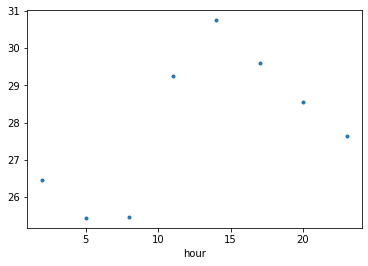

In [23]:
_df.groupby('hour').mean()['T_C'].plot(marker='.')

<AxesSubplot:xlabel='hour'>

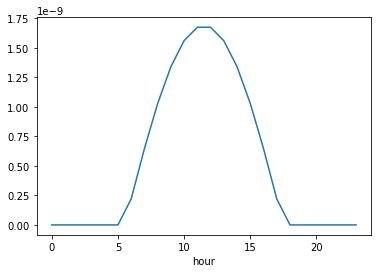

In [24]:
_df.groupby('hour').mean()['emiisop'].plot()

<AxesSubplot:xlabel='hour'>

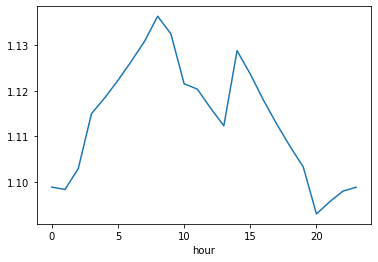

In [25]:
_df.groupby('hour').mean()['POM'].plot()

<AxesSubplot:xlabel='hour'>

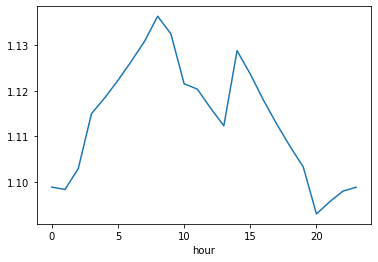

In [26]:
_df.groupby('hour').mean()['POM'].plot()

<AxesSubplot:xlabel='hour'>

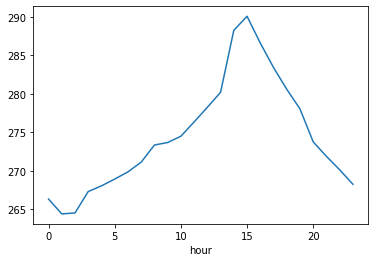

In [27]:
_df.groupby('hour').mean()['N100'].plot()

## Read in observations

In [28]:
ds_obs = xr.open_dataset(fn_obs_comb_data_full_time, engine='netcdf4')

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
(click 8.0.1 (/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages), Requirement.parse('click<8,>=4.0'), {'rasterio'})
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [29]:
ds_obs = ds_obs.sel(time_traj=0)

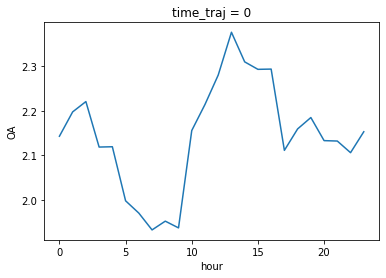

In [30]:
ds_obs['OA'].groupby(ds_obs['time.hour']).median().plot()

In [31]:
varl = [
    #'pnsd',
 'Pressure_reanalysis',
 'Potential_Temperature_reanalysis',
 'Temperature_reanalysis',
 'Rainfall',
 'Mixing_Depth',
 'Relative_Humidity',
 'Specific_Humidity_reanalysis',
 'Mixing_Ratio',
 #'Terrain_Altitude',
 'Solar_Radiation',
 #'x',
 #'y',
 #'z',
 'condensation_sink',
 #'pnsd_nolog',
 'N50-500',
 'N100-500',
 'N200-500',
 'timeUTC-3',
 #'hour',
 'pressure',
 'temperature',
 'humidity',
 #'wind_dir',
 'precip',
 #'Solar_inc_Wm2',
 #'Solar_out_Wm2',
 #'wind_speed',
 #'wind_speed_v',
 'OA',
 #'OA_STP'
]
ds_obs[varl].squeeze().to_dataframe()

,Pressure_reanalysis,Potential_Temperature_reanalysis,Temperature_reanalysis,Rainfall,Mixing_Depth,Relative_Humidity,Specific_Humidity_reanalysis,Mixing_Ratio,Solar_Radiation,condensation_sink,N50-500,N100-500,N200-500,timeUTC-3,pressure,temperature,humidity,precip,OA,time_traj
time,,,,,,,,,,,,,,,,,,,,
2014-03-10 15:00:00,974.8,305.5,303.3,0.0,1437.6,55.1,15.1,15.4,681.2,0.001503,316.350342,259.764876,123.407339,2014-03-10 16:00:00,986.86,31.46,57.56,0.0,0.990,0
2014-03-10 16:00:00,974.1,305.5,303.2,0.0,1268.8,56.0,15.2,15.6,596.6,0.001285,288.441016,221.149397,102.265441,2014-03-10 17:00:00,986.21,31.62,59.16,0.0,1.620,0
2014-03-10 17:00:00,974.9,304.5,302.3,0.0,863.0,60.5,15.6,16.0,504.7,0.001317,294.872421,223.659092,104.508354,2014-03-10 18:00:00,986.25,30.01,66.29,0.0,1.660,0
2014-03-10 18:00:00,975.8,303.5,301.4,0.0,453.1,65.1,15.9,16.3,412.7,0.001469,323.442362,243.316332,120.456843,2014-03-10 19:00:00,986.47,28.18,70.54,0.0,0.985,0
2014-03-10 19:00:00,976.6,302.5,300.5,0.0,43.2,69.7,16.1,16.6,320.7,0.001441,323.533283,236.004666,116.970997,2014-03-10 20:00:00,987.01,27.40,82.67,0.0,2.420,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-28 05:00:00,979.4,298.0,296.2,0.0,254.7,85.8,15.3,15.7,18.9,0.000014,2.886702,2.418678,1.160755,2019-01-28 06:00:00,NaN,NaN,NaN,NaN,NaN,0
2019-01-28 06:00:00,980.0,297.9,296.2,0.0,363.3,88.0,15.7,16.1,38.1,0.000013,2.189876,2.165097,1.267096,2019-01-28 07:00:00,NaN,NaN,NaN,NaN,NaN,0
2019-01-28 07:00:00,980.7,297.8,296.1,0.0,472.0,90.2,16.0,16.4,57.4,0.000011,2.075599,1.882887,0.938360,2019-01-28 08:00:00,NaN,NaN,NaN,NaN,NaN,0


In [32]:
dic_df_pre['Observations']=dict()
dic_df_pre['Observations']['Observations'] = ds_obs[varl].squeeze().to_dataframe()
dic_df_pre['Observations']['Observations'].index = pd.to_datetime(dic_df_pre['Observations']['Observations'].index)

In [33]:
mod2cases['Observations']= ['Observations']

## Set uo dic with all OA values from models

In [34]:
dic_df_mod_case = dic_df_pre

In [35]:
dic_mod_oa = dict()
#dic_mod_soa = dict()
dic_mod_all = dict()


for mod in models:
    dic_mod_oa[mod] = dict()
    #dic_mod_soa[mod] = dict()
    dic_mod_all[mod] = dict()
    for ca in di_mod2cases[mod]:
        dic_mod_oa[mod][ca] = dict()
        #dic_mod_soa[mod][ca] = dict()
        dic_mod_all[mod][ca] = dict()
    
    
for mo in models:
    print(mo)
    for ca in di_mod2cases[mo]:
        print(ca)
        _df = dic_df_mod_case[mo][ca]
        dic_mod_oa[mo][ca] =_df['OA']
        #dic_mod_soa[mo][ca][i] =_df['SOA']
        dic_mod_all[mo][ca] =_df
    



ECHAM-SALSA
SALSA_BSOA_feedback
NorESM
OsloAero_intBVOC_f09_f09_mg17_fssp
EC-Earth
ECE3_output_Sara
UKESM
AEROCOMTRAJ


<AxesSubplot:xlabel='time'>

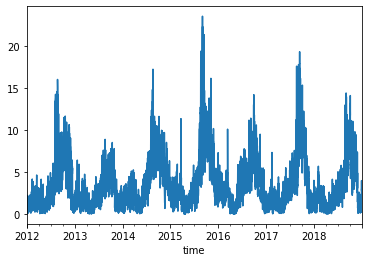

In [36]:
dic_df_pre['ECHAM-SALSA']['SALSA_BSOA_feedback']['OA'].plot()

(390048.0, 390792.0)

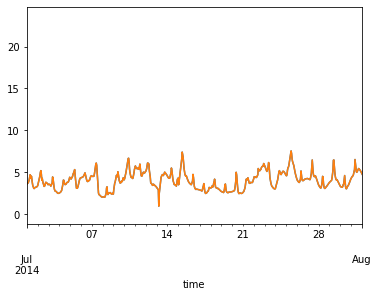

In [37]:
dic_df_pre['ECHAM-SALSA']['SALSA_BSOA_feedback'].resample('h').ffill(limit=1)['OA'].plot()         
dic_df_pre['ECHAM-SALSA']['SALSA_BSOA_feedback']['OA'].plot()
plt.xlim(['2014-07','2014-08'])

## Merge with observations:

In [38]:
dic_df_mod_case = dic_df_pre.copy()

In [39]:
mask_obs_OA =  dic_df_pre['Observations']['Observations']['OA'].notnull()

In [40]:
_df = dic_df_pre['Observations']['Observations']['OA'].rename('Obs')

df_OA_all = pd.DataFrame(_df)
df_OAG_all = pd.DataFrame(_df)

In [41]:
for mod in dic_df_pre.keys():
    if mod=='Observations':
        continue
    print(mod)
    for ca in dic_df_pre[mod].keys():
        if len(dic_df_pre[mod].keys())==1:
            use_name = mod
        else: 
            use_name = f'{mod}: {ca}'
        df_OA_all[use_name] = dic_df_pre[mod][ca]['OA']
        df_OAG_all[use_name] = dic_df_pre[mod][ca]['OAG']


#df_OA_all = df_OA_all[df_OA_all[mod].notna()]
df_OA_all = df_OA_all[df_OA_all['Obs'].notna()]
#df_OAG_all = df_OAG_all[df_OAG_all[mod].notna()]
df_OAG_all = df_OAG_all[df_OAG_all['Obs'].notna()]

ECHAM-SALSA
NorESM
EC-Earth
UKESM


Small error due to time change in models but only 3 data points each summer. 


In [42]:
orgname={'NorESM' : 'OA',
         'ECHAM-SALSA': 'OA',
         'EC-Earth':'OA',
        }

In [43]:
seasons2months = {'DJF':[12,1,2],
        'MAM': [3,4,5],
        'JJA':[6,7,8],
        'SON':[9,10,11],
       }

In [44]:
seasons2months2 = {'JFM': [ 1, 2,3], 'AMJ': [ 4, 5,6], 'JAS': [ 7, 8,9], 'OND': [ 10, 11,12]}

### Calculate anomaly from daily average

In [45]:
df_anom_OA = df_OA_all-df_OA_all.resample('D').mean().resample('h').ffill(limit=24)
df_anom_OAG = df_OAG_all-df_OAG_all.resample('D').mean().resample('h').ffill(limit=24)

In [46]:
df_anom_OAG = df_anom_OAG[df_anom_OAG['Obs'].notna()]
df_anom_OA = df_anom_OA[df_anom_OA['Obs'].notna()]

In [47]:
df_anom_OA

,Obs,ECHAM-SALSA,NorESM,EC-Earth,UKESM
time,,,,,
2014-03-10 15:00:00,-0.510556,-0.269289,-1.957228,0.121814,NaN
2014-03-10 16:00:00,0.119444,0.001331,-1.481358,0.113202,NaN
2014-03-10 17:00:00,0.159444,0.217570,-0.700363,0.094538,-0.382727
2014-03-10 18:00:00,-0.515556,0.246898,0.257059,0.066040,NaN
2014-03-10 19:00:00,0.919444,0.180170,0.645709,0.034919,NaN
...,...,...,...,...,...
2017-12-18 20:00:00,0.032870,-0.276129,2.749918,0.079960,-0.108347
2017-12-18 21:00:00,-0.155014,-0.231134,2.392537,-0.027465,NaN
2017-12-18 22:00:00,-0.095856,-0.168066,1.515836,-0.100343,NaN


In [48]:
linestyle_dic = {
    'Obs': 'solid',
    'NorESM':'dashdot',
    'UKESM':'dashdot',
    'ECHAM-SALSA':'-.',
    'EC-Earth':'-.',
}

## Choose months: 

In [49]:
months = [1,2,3,4,5,6,7,8,9,10,11,12]
df_OA_all = df_OA_all[df_OA_all.index.month.isin(months)]
df_OAG_all = df_OAG_all[df_OAG_all.index.month.isin(months)]                      

df_anom_OA = df_anom_OA[df_anom_OA.index.month.isin(months)]
df_anom_OAG = df_anom_OAG[df_anom_OAG.index.month.isin(months)]

## Time series

In [50]:
linestyle_dic['Observations'] = linestyle_dic['Obs']

Obs
ECHAM-SALSA
NorESM
EC-Earth
UKESM
Plots/ATTO/evalOA_echam_ECHAM-SALSA_NorESM_EC-Earth_UKESM_timeseries_ATTO.png


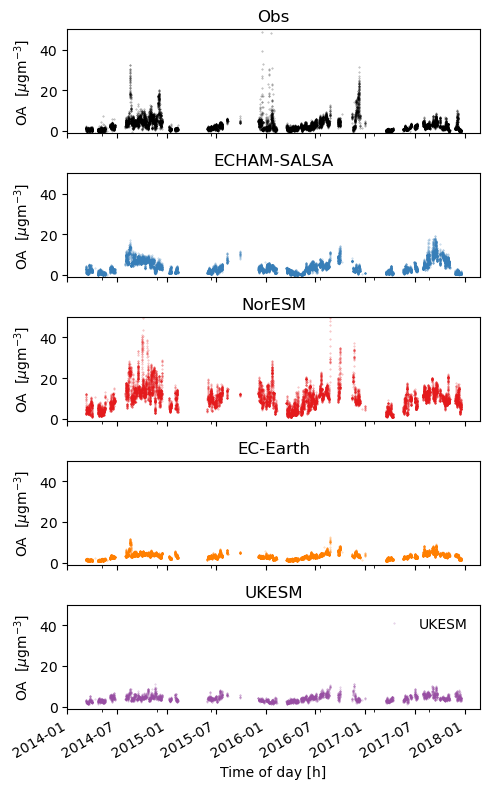

In [51]:
fig, axs = plt.subplots(5,1, sharex=True, sharey=True, figsize=[5,8], dpi=100)
ax = axs[1]
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')

for ax, mo in zip( axs, df_anom_OA.columns):
 
    _df_anom_OA = df_OA_all.copy()
    _df_anom_OA = _df_anom_OA[_df_anom_OA['Obs'].notna()]#.dropna(axis=0)
    print(mo)
    if mo=='Obs':
        c = 'k'
        ls = 'solid'
        c2 = 'w'
        
    else:
        c=cdic_model[mo]
        ls = linestyle_dic[mo]
        c2='k'
    _df = _df_anom_OA[mo]
        
    _df.plot(ax=ax,c=c,
             #linestyle=ls,
             marker='.', 
             linewidth=0,
             markersize=.7,
             alpha=.4,
             rasterized=True,
             label=mo)
    
    ax.set_title(mo)
    #'OsloAeroSec',)# c='k')
        #ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
    # ax.set_title("$OA'$: Average diurnal anomaly") 
#ax.set_title(f"{seas} $OA'$: Median diurnal anomaly") 

#    ax.set_ylim([-2,2])

ax.legend(frameon=False)


plt.legend(frameon=False)
ax.set_xlabel('Time of day [h]')
for ax in axs: 
    ax.set_ylabel('OA  [$\mu$gm$^{-3}$]')
plt.tight_layout()

#ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,])
plt.ylim([-1,50])
#ax.set_xlim([0,23])
fn = make_fn_eval('_'.join(models), 'timeseries')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))
print(fn)

In [103]:
seasons2months2

{'JFM': [1, 2, 3], 'MJJ': [5, 6, 7], 'JA': [7, 8], 'SON': [9, 10, 11]}

In [104]:
seasons2months

{'DJF': [12, 1, 2], 'MAM': [3, 4, 5], 'JJA': [6, 7, 8], 'SON': [9, 10, 11]}

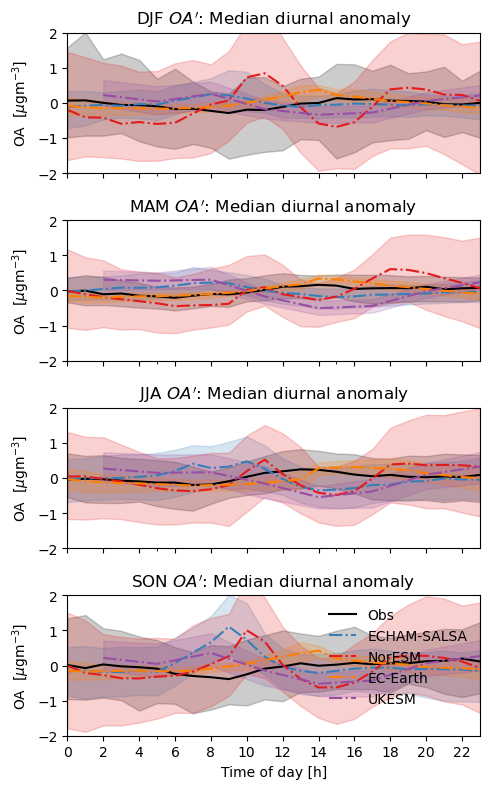

In [89]:
fig, axs = plt.subplots(4,1, sharex=True, figsize=[5,8], dpi=100)
ax = axs[1]
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')

for seas, ax in zip(seasons2months, axs):
    
    _df_anom_OA = df_anom_OA[df_anom_OA.index.month.isin(seasons2months[seas])]
    #_df_anom_OA = _df_anom_OA.dropna(axis=0)
    for mod in df_anom_OA.columns:
        if mod=='Obs':
            c = 'k'
        else:
            c=cdic_model[mod]
            #continue
        if mod=='UKESM':
            # 3h resolution so need to drop nans
            _df_anom_OA = _df_anom_OA[_df_anom_OA[mod].notna()]

        ls = linestyle_dic[mod]
        _df_gb = _df_anom_OA[mod].groupby(_df_anom_OA.index.hour)
        _df_gbm = _df_gb.median()
        _df_gbstd = _df_gb.std()
        _df_gb33 = _df_gb.quantile(.84)
        _df_gb66 = _df_gb.quantile(.16)
        
        
        _df_gbm.plot(ax=ax,c=c,
                                                               linestyle=ls,
                                                               label=mod)#'OsloAeroSec',)# c='k')
        ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
    # ax.set_title("$OA'$: Average diurnal anomaly") 
    ax.set_title(f"{seas} $OA'$: Median diurnal anomaly") 

    ax.set_ylim([-2,2])

ax.legend(frameon=False)


plt.legend(frameon=False)
ax.set_xlabel('Time of day [h]')
for ax in axs: 
    ax.set_ylabel('OA  [$\mu$gm$^{-3}$]')
plt.tight_layout()

ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,])

ax.set_xlim([0,23])
fn = make_fn_eval('_'.join(models), 'diurnal_mean_dev')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))

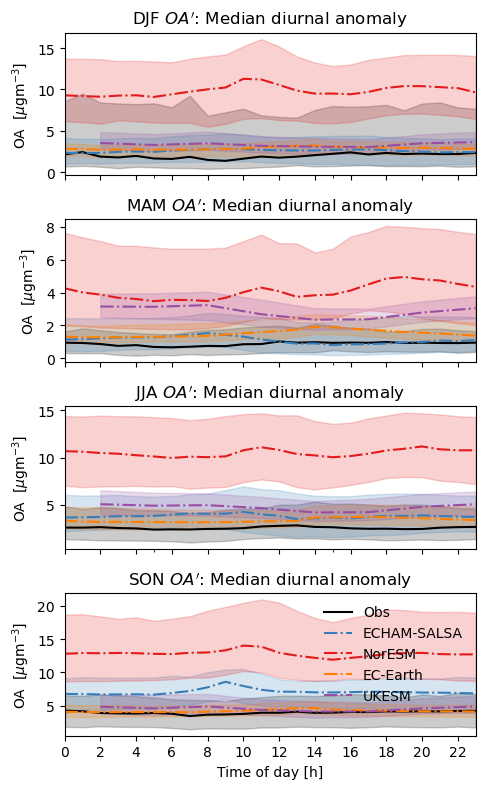

In [90]:
fig, axs = plt.subplots(4,1, sharex=True, figsize=[5,8], dpi=100)
ax = axs[1]
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')

for seas, ax in zip(seasons2months, axs):
    
    _df_OA_all = df_OA_all[df_OA_all.index.month.isin(seasons2months[seas])]
    #_df_OA_all = _df_OA_all.dropna(axis=0)
    for mod in df_OA_all.columns:
        if mod=='Obs':
            c = 'k'
        else:
            c=cdic_model[mod]
            #continue
        if mod=='UKESM':
            # 3h resolution so need to drop nans
            _df_OA_all = _df_OA_all[_df_OA_all[mod].notna()]

        ls = linestyle_dic[mod]
        _df_gb = _df_OA_all[mod].groupby(_df_OA_all.index.hour)
        _df_gbm = _df_gb.median()
        _df_gbstd = _df_gb.std()
        _df_gb33 = _df_gb.quantile(.84)
        _df_gb66 = _df_gb.quantile(.16)
        
        
        _df_gbm.plot(ax=ax,c=c,
                                                               linestyle=ls,
                                                               label=mod)#'OsloAeroSec',)# c='k')
        ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
    # ax.set_title("$OA'$: Average diurnal anomaly") 
    ax.set_title(f"{seas} $OA'$: Median diurnal anomaly") 

    #ax.set_ylim([-3,3])

ax.legend(frameon=False)


plt.legend(frameon=False)
ax.set_xlabel('Time of day [h]')
for ax in axs: 
    ax.set_ylabel('OA  [$\mu$gm$^{-3}$]')
plt.tight_layout()

ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,])

ax.set_xlim([0,23])
fn = make_fn_eval('_'.join(models), 'diurnal_mean')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))

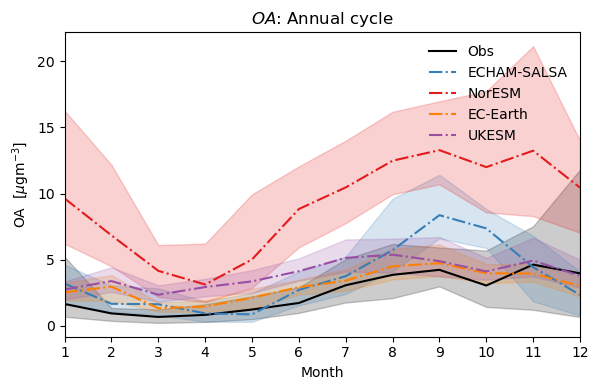

In [91]:
fig, axs = plt.subplots(1,1, sharex=True, figsize=[6,4], dpi=100)

ax = axs
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')

    
_df_OA_all = df_OA_all.copy()#[df_OA_all.index.month.isin(seasons2months[seas])]
#_df_OA_all = _df_OA_all.dropna(axis=0)
for mod in df_OA_all.columns:
    if mod=='Obs':
        c = 'k'
    else:
        c=cdic_model[mod]
    ls = linestyle_dic[mod]
    _df_gb = _df_OA_all[mod].groupby(_df_OA_all.index.month)
    _df_gbm = _df_gb.median()
    _df_gbstd = _df_gb.std()
    _df_gb33 = _df_gb.quantile(.84)
    _df_gb66 = _df_gb.quantile(.16)
    
    _df_gbm.plot(ax=ax,c=c,
                                                               linestyle=ls,
                                                               label=mod)#'OsloAeroSec',)# c='k')
    ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
    # ax.set_title("$OA'$: Average diurnal anomaly") 
ax.set_title(f"$OA$: Annual cycle") 

    #ax.set_ylim([-3,3])

ax.legend(frameon=False)


plt.legend(frameon=False)
ax.set_xlabel('Month')
ax.set_ylabel('OA  [$\mu$gm$^{-3}$]')
plt.tight_layout()

ax.set_xticks(np.arange(1,13))

ax.set_xlim([1,12])
fn = make_fn_eval('_'.join(models), 'diurnal_mean')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))

In [92]:
import matplotlib as mpl

In [93]:
mi = np.min(df_OA_all[df_OA_all['Obs']>0]['Obs'])*60
ma = np.max(df_OA_all[df_OA_all['Obs']>0]['Obs'])*.9
bins_ = 10 ** np.linspace(np.log10(mi), np.log10(ma), 50)

In [94]:
seasons2months2={
    'JFM': [1, 2, 3],
    'MJJ': [5,6,7],
    'JA': [7,8],
    'SON': [9,10,11],
}

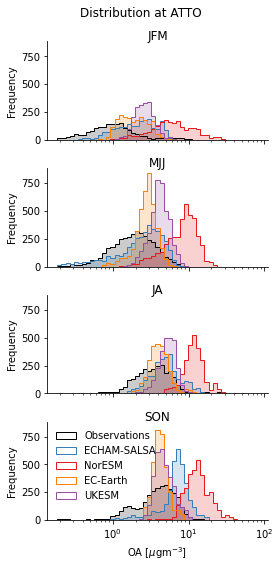

In [95]:
fig, axs = plt.subplots(4,figsize = [4,8,],sharex=True, sharey=True)

for seas,ax in zip(seasons2months2, axs.flatten()):
    df_OA_all_sub = df_OA_all.copy()[df_OA_all['Obs'].notna()]
    if 'UKESM' in df_OA_all.columns:
        mo = 'UKESM'
        df_OA_all_sub[mo] =df_OA_all_sub.loc[:,mo].ffill(limit=3).copy()
        df_OA_all_sub[mo] =df_OA_all_sub[mo][df_OA_all_sub['Obs'].notna()]
        
    df_OA_all_sub = df_OA_all_sub[df_OA_all_sub.index.month.isin(seasons2months2[seas])].copy()

    df_OA_all_sub['Obs'].plot.hist(bins=bins_, alpha=1, 
                                     color='k',
                                     label='Observations',
                                   ax = ax,
                                   histtype='step',
                                  )
    df_OA_all_sub['Obs'].plot.hist(bins=bins_, alpha=0.2, 
                                     color='k',
                                     label='__nolabel__',
                                   ax = ax,
                                  )

    for mo in models:
        df_OA_all_sub[mo].plot.hist(bins=bins_, alpha=1, 
                                     color=cdic_model[mo],
                                     label=mo,
                                    ax = ax,
                                    histtype='step'
                                    )
        df_OA_all_sub[mo].plot.hist(bins=bins_, alpha=0.2, 
                                     color=cdic_model[mo],
                                     label='__nolabel__',
                                    ax = ax
                                    )

        ax.set_xscale('log')
    #_mod_an.plot.hist(bins=bins_, alpha=0.5,label='OsloAero, SOA')

    ax.set_xlabel('OA [$\mu$gm$^{-3}$]')

    ax.set_title(f'{seas}', y=.95)

ax.legend(frameon=False)
plt.suptitle('Distribution at ATTO')
fn = make_fn_eval('noresm_echam_seasons2','hist')
fig.tight_layout()
sns.despine(fig)
plt.savefig(fn, dpi=300)


plt.savefig(fn.with_suffix('.pdf'), dpi=300)

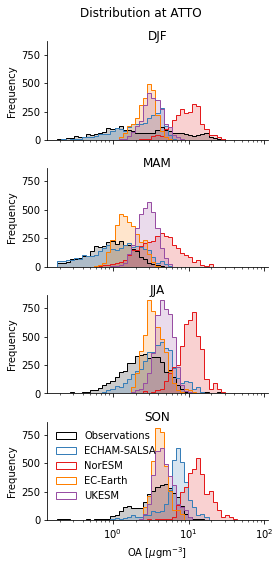

In [96]:
fig, axs = plt.subplots(4,figsize = [4,8,],sharex=True, sharey=True)

for seas,ax in zip(seasons2months, axs.flatten()):
    df_OA_all_sub = df_OA_all.copy()[df_OA_all['Obs'].notna()]
    if 'UKESM' in df_OA_all.columns:
        mo = 'UKESM'
        df_OA_all_sub[mo] =df_OA_all_sub.loc[:,mo].ffill(limit=3).copy()
        df_OA_all_sub[mo] =df_OA_all_sub[mo][df_OA_all_sub['Obs'].notna()]
        
    df_OA_all_sub = df_OA_all_sub[df_OA_all_sub.index.month.isin(seasons2months[seas])].copy()

    df_OA_all_sub['Obs'].plot.hist(bins=bins_, alpha=1, 
                                     color='k',
                                     label='Observations',
                                   ax = ax,
                                   histtype='step',
                                  )
    df_OA_all_sub['Obs'].plot.hist(bins=bins_, alpha=0.2, 
                                     color='k',
                                     label='__nolabel__',
                                   ax = ax,
                                  )
    for mo in models:
        df_OA_all_sub[mo].plot.hist(bins=bins_, alpha=1, 
                                     color=cdic_model[mo],
                                     label=mo,
                                    ax = ax,
                                    histtype='step'
                                    )
        df_OA_all_sub[mo].plot.hist(bins=bins_, alpha=0.2, 
                                     color=cdic_model[mo],
                                     label='__nolabel__',
                                    ax = ax
                                    )
    ax.set_xscale('log')
    #_mod_an.plot.hist(bins=bins_, alpha=0.5,label='OsloAero, SOA')

    ax.set_xlabel('OA [$\mu$gm$^{-3}$]')

    ax.set_title(f'{seas}', y=.95)

ax.legend(frameon=False)
plt.suptitle('Distribution at ATTO')
fn = make_fn_eval('noresm_echam_seasons','hist')
fig.tight_layout()
sns.despine(fig)
plt.savefig(fn, dpi=300)


plt.savefig(fn.with_suffix('.pdf'), dpi=300)

In [97]:
import numpy as np

In [98]:
_diff = (df_OA_all.drop(['Obs'],axis=1).T - df_OA_all['Obs']).T

df_OA_incDiff = df_OA_all.copy()

for mo in _diff.columns:
    df_OA_incDiff[f'{mo}_diff'] = _diff[mo]

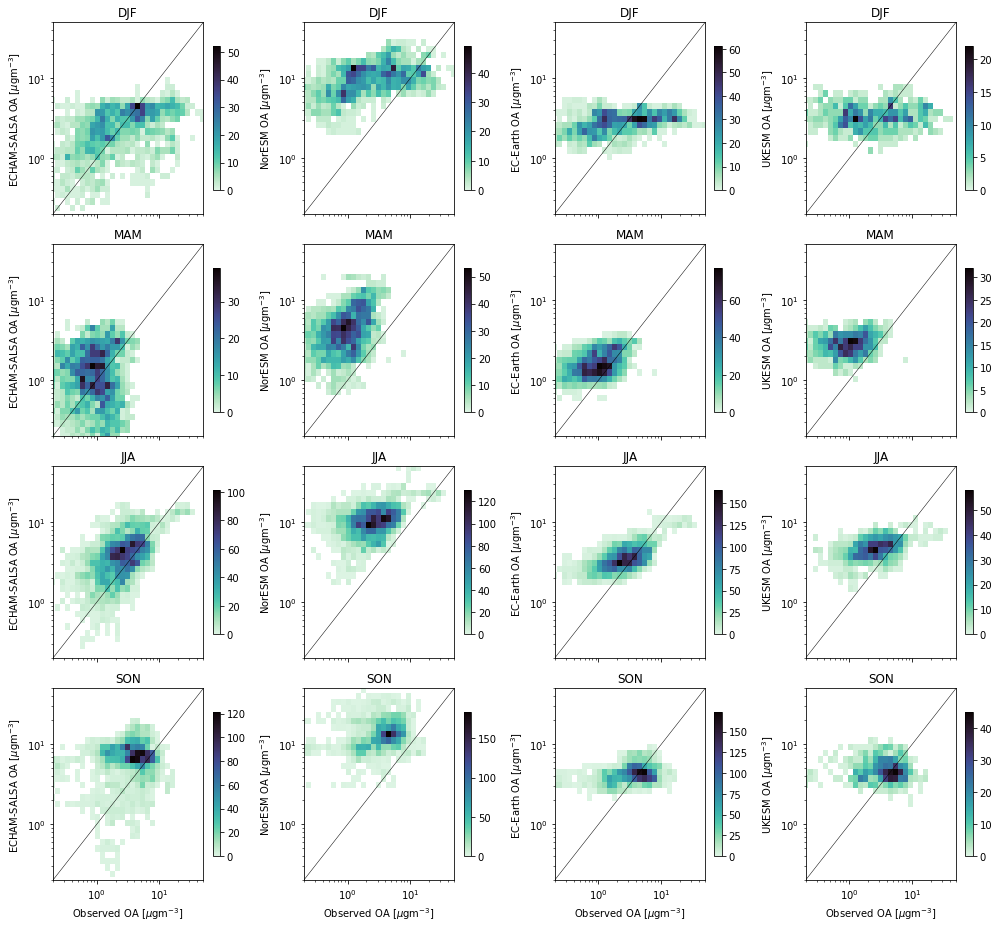

In [99]:
fig, axs = plt.subplots(4,4,figsize = [14,13],sharex=True, sharey=False)

for seas,i in zip(['DJF','MAM','JJA','SON'], range(4)):
    axs_sub = axs[i]
    _df = df_OA_all[df_OA_all.index.month.isin(seasons2months[seas])]
    _df = _df[_df['Obs']>0]
    bins = np.linspace(-.9,3,50)

    #_df['hour'] = _df.index.hour
    for mo, ax in zip(models,axs_sub):
        sns.histplot(y=mo, x='Obs',
                ax=ax,
                cmap = sns.color_palette("mako_r", as_cmap=True),
                log_scale=(True, True),
                     cbar=True, cbar_kws=dict(shrink=.75),
                
                     bins=(bins,bins,),
                 
                data = _df)


        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlim([0.2,50])
        ax.set_ylim([0.2,50])

        ax.set_ylabel(f'{mo} OA '+'[$\mu$gm$^{-3}$]')
        ax.set_xlabel('Observed OA [$\mu$gm$^{-3}$]')

        ax.set_title(seas)


        lims = ax.get_xlim()
        ax.plot(lims,lims,'k', linewidth=.5)

fig.tight_layout()

fn = make_fn_eval('_'.join(models),'2Dhist_seasons_OA')
fig.savefig(fn, dpi=300)
fig.savefig(fn.with_suffix('.pdf'), dpi=300)

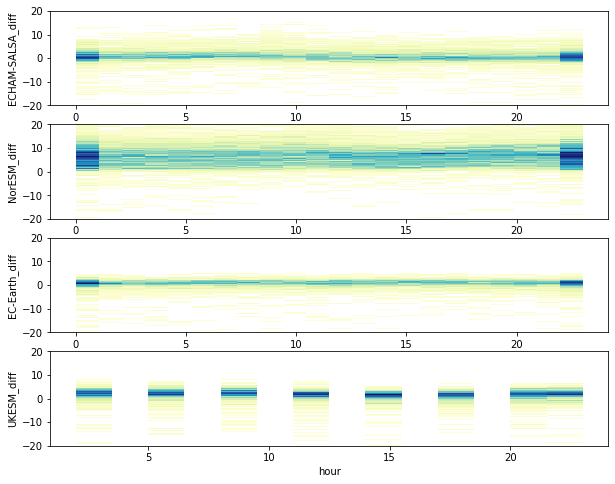

In [100]:
fig, axs = plt.subplots(4,sharey=True, figsize=[10,8])
ax = axs[0]
_df = df_OA_incDiff
_df['hour'] = _df.index.hour
for mo, ax in zip(models,axs.flatten()):
    sns.histplot(y=f'{mo}_diff', x=f'hour',#orbins=bins_, alpha=0.5, 
                                     #hue=f'Obs', 
                #col = 'dir',
                ax=ax,
                #alpha=0.4,
                #palette='viridis',
                cmap='YlGnBu',
                 
                
                #edgecolors=None,
                data = _df)

    #ax.set_yscale('log')
    # ax.set_xscale('symlog')
    ax.set_ylim([-20,20])
    #ax.set_ylim([0.1,30])

    #ax.set_xlabel(f'{mo} OA '+'[$\mu$gm$^{-3}$]')
    #ax.set_ylabel('Observed OA [$\mu$gm$^{-3}$]')



    lims = ax.get_xlim()
    #ax.plot(lims,lims,'k', linewidth=.5)

    #_df.groupby('hour').count().plot(ax = ax.twinx())
    
fn = make_fn_eval('_'.join(models),'2dhist_dist_time')
fig.savefig(fn, dpi=300)
fig.savefig(fn.with_suffix('.pdf'), dpi=300)